In [1]:
from jax import config, jit
config.update("jax_enable_x64", True)
import jax
try:
    jax.devices()
except:
    config.update('jax_platforms','cpu')
    print('gpu is not recognized')
from jax import numpy as jnp

from timeseries_models.state_space_model import StateSpaceModel
from timeseries_models import state_model, observation_model
import pandas as pd
from jax import numpy as jnp

gpu is not recognized


In [2]:
from pycolormap_2d import ColorMap2DTeuling2
from matplotlib import pyplot as plt
import pickle
cmap = ColorMap2DTeuling2(range_x=(-3, 3), range_y=(-3, 3))
with open('../data/fig7_vector_field_pnlss.pkl', 'rb') as f:
    results_ssm = pickle.load(f)
    
with open('../data/fig7_vector_field_darts.pkl', 'rb') as f:
    results = pickle.load(f)

In [3]:
for data_name in results.keys():
    results[data_name] = results[data_name] | results_ssm[data_name]

dict_keys(['RNN', 'NBEATS', 'Transformer', 'PNL-SS', 'RBF-SS'])

In [4]:
from scipy.integrate import odeint
import numpy as np

def vanderpol(x, t, mu=1.):
    x, y = x[..., 0], x[..., 1]
    return np.array([y, mu * (1 - x ** 2) * y - x])

def fitzhugh_nagumo(x, t, a=0.7, b=0.8, tau=12.5):
    x, y = x[..., 0], x[..., 1]
    return np.array([x - x ** 3 / 3 - y + a, (x + b - y) / tau]) * 4

num_points = 20
data_sets = ['vanderpol', 'fitzhugh_nagumo']
n_pred =100
time = np.arange(0, 10.1, .1)
traj_fhn = np.empty((num_points, num_points, n_pred+1, 2))
traj_vnp = np.empty((num_points, num_points, n_pred+1, 2))

x_range = jnp.linspace(-3, 3, num_points)
y_range = jnp.linspace(-3, 3, num_points)

mesh = jnp.meshgrid(x_range, y_range)
mesh = jnp.stack(mesh, axis=-1)

time = np.arange(0, 120, .1)
x0 = np.array([0, 2.])
x_mu = odeint(fitzhugh_nagumo, x0, time)
mu_fhn = np.mean(x_mu, axis=0)
std_fhn = np.std(x_mu, axis=0)
x_mu = odeint(vanderpol, x0, time)
mu_vnp = np.mean(x_mu, axis=0)
std_vnp = np.std(x_mu, axis=0)
#std_x, std_y = std[0], std[1]
n_pred =100
time = np.arange(0, 10.1, .1)
for i in range(num_points):
    for j in range(num_points):
        x0 = mesh[i,j]
        x0_fhn = x0 * std_fhn + mu_fhn
        traj_fhn[i,j] = odeint(fitzhugh_nagumo, x0_fhn, time)
        x0_vnp = x0 * std_vnp + mu_vnp
        traj_vnp[i,j] = odeint(vanderpol, x0_vnp, time)
results['fitzhugh_nagumo']['True'] = traj_fhn
results['vanderpol']['True'] = traj_vnp


for data_name in data_sets:
    time = np.arange(0, 120, .1)
    x0 = np.array([0, 2.])
    if data_name == 'fitzhugh_nagumo':
        mu_x, mu_y = mu_fhn[0], mu_fhn[1]
        std_x, std_y = std_fhn[0], std_fhn[1]
    elif data_name == 'vanderpol':
        mu_x, mu_y = mu_vnp[0], mu_vnp[1]
        std_x, std_y = std_vnp[0], std_vnp[1]

    
    #x_mu = odeint(fitzhugh_nagumo, x0, time)
    #x_mu = odeint(vanderpol, x0, time)
    #x_mu = odeint(lorentz, x0, time)[:,[1,2,0]]
    # standardize
    #x_mu = x_mu
    #x_mu = (x_mu - x_mu.mean(0)) / x_mu.std(0)
    results[data_name]['True'][...,0] = (results[data_name]['True'][...,0]  - mu_x) / std_x
    results[data_name]['True'][...,1] = (results[data_name]['True'][...,1]  - mu_y) / std_y
        

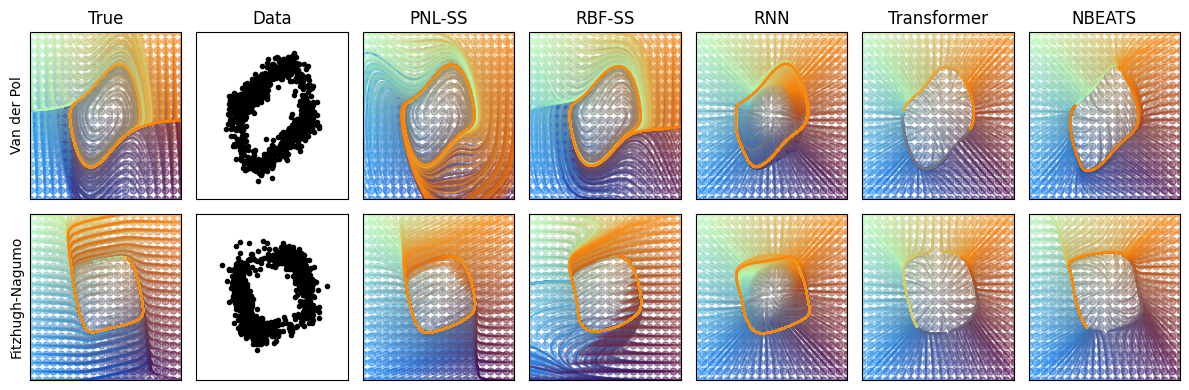

In [6]:
# make font size larger
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'axes.labelsize': 18})
# standard matplotlib style
plt.style.use('default')
fig = plt.figure(figsize=(12,4))
model_colors = ['C0', 'C2', 'C3']
data_sets = list(results.keys())
models = list(results[data_sets[0]].keys())

model_names = ['True', 'Data', 'PNL-SS', 'RBF-SS', 'RNN', 'Transformer', 'NBEATS']
for idata, data_name in enumerate(data_sets):
    for imodel, model_name in enumerate(model_names):
        ax = fig.add_subplot(len(data_sets), len(model_names), imodel + len(model_names) * idata + 1)
        if model_name == 'Data':
                df = pd.read_csv(f'../data/{data_name}_data.csv', header=None)
                df.columns = ['x', 'y']
                df['time'] = jnp.arange(0, len(df))
                x = jnp.array(df[['x', 'y']].to_numpy())
                x_train, x_test = x[:len(x) * 5 // 6], x[len(x)* 5 // 6:]
                ax.plot(x_train[:, 0], x_train[:, 1], 'k.', label='Data')
        else:
            traj = results[data_name][model_name]
            for i in range(num_points):
                for j in range(num_points):
                    color = cmap(traj[i,j,0,0], traj[i,j,0,1]) / 255
                    ax.plot(traj[i,j,:,0], traj[i,j,:,1], color=color, alpha=0.5, linestyle='-')
                    ax.plot(traj[i,j,0,0], traj[i,j,0,1], color=color, marker='o', alpha=.5, ms=5)
        ax.set_xlim(-3,3)
        ax.set_ylim(-3,3)
        if imodel == 0:
            if data_name == 'vanderpol':
                ax.set_ylabel('Van der Pol')
            else:
                ax.set_ylabel('Fitzhugh-Nagumo')
            #ax.set_ylabel(data_name)
        if idata == 0:
            if model_name == 'NonLinear':
                ax.set_title('PNL-SS')
            else:
                ax.set_title(model_name)
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
fig.savefig('../fig/Fig7_dynamical_systems_comparison.pdf')